In [1]:
#imports
import pandas as pd
from IPython.display import display
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import StratifiedKFold
import warnings
import deepchem as dc
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from DeepPurpose import utils, dataset, CompoundPred
import exmol

# Configuring warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, message='.*X does not have valid feature names.*')

#custom imports
from utils.canonicalize import *
from utils.featgen import *
from utils.samplers import *
from utils.plots import *
from utils.rfcv import *
from utils.models_config import *

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
c:\Users\stebi\anaconda3\Lib\site-packages\transformers\adapters\__init__.py:27: FutureWarning: The `adapter-transformers` package is deprecated and replaced by the `adapters` package. See https://docs.adapterhub.ml/transitioning.html.
  warnings.warn(
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Users\stebi\anaconda3\Lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


### Import datasets and initial preprocessing

In [2]:
df = pd.read_csv(r"./data/train.csv")
test = pd.read_csv(r"./data/test.csv")

In [3]:
df

smiles  BBB
0          C[N+]1(C)CCC(OC(=O)C(O)(c2ccccc2)C2CCCC2)C1    0
1        C[N+]1(C)CCCC(OC(=O)C(O)(c2ccccc2)c2ccccc2)C1    0
2     C[N+]12CCC(CC1)C(OC(=O)C(O)(c1ccccc1)c1ccccc1)C2    0
3      CC(C)[N+](C)(CCOC(=O)C1c2ccccc2Oc2ccccc21)C(C)C    0
4         CC(C)[N+]1(C)C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2    0
...                                                ...  ...
1932    OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1    1
1933                               O=C(NCc1ccccc1)OCCO    1
1934                            S=P(N1CC1)(N1CC1)N1CC1    1
1935                S=C(NC1CCCCC1)N1CCC(c2cnc[nH]2)CC1    1
1936                 O=C1CC2SC(C3(O)CN4C(=O)CC4S3)CN12    1

[1937 rows x 2 columns]

In [4]:
test

smiles  BBB
0    [H]C([H])([H])Oc1ccc(-n2nc3c4ccc(OC([H])([H])[...    1
1    [H]C([H])([H])Oc1ccc2c3nn(-c4ccc(OC)cc4)c(=O)c...    1
2    [H]C([H])([H])Oc1ccccc1-n1nc2c3cc(Cl)ccc3[nH]c...    1
3                                                 [Ar]    1
4                     Nc1nc2c(ncn2COC(CO)CO)c(=O)[nH]1    1
..                                                 ...  ...
522                         CNC(=NC#N)NCCSCc1[nH]cnc1C    0
523            CN=C(C[N+](=O)[O-])NCCSCc1ccc(CN(C)C)o1    0
524                                              S=C=S    1
525                   CN(C)CCCN1c2ccccc2S(=O)c2ccccc21    1
526                                  Cc1csc(NC(=N)N)n1    1

[527 rows x 2 columns]

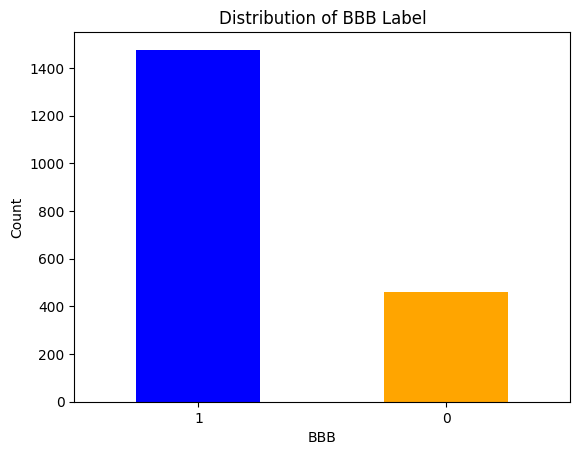

In [5]:
counts = plot_binary_distribution(df, 'BBB')

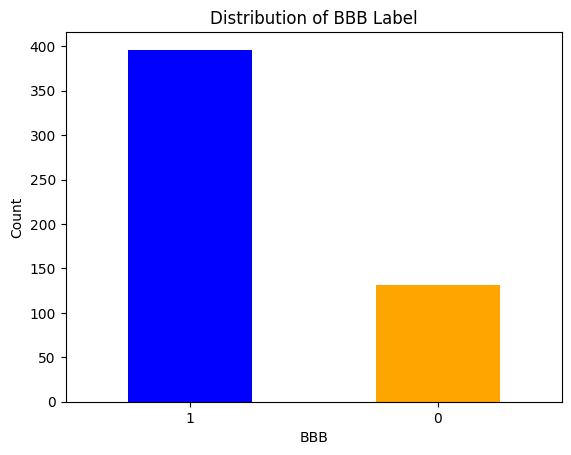

In [6]:
counts = plot_binary_distribution(test, 'BBB')

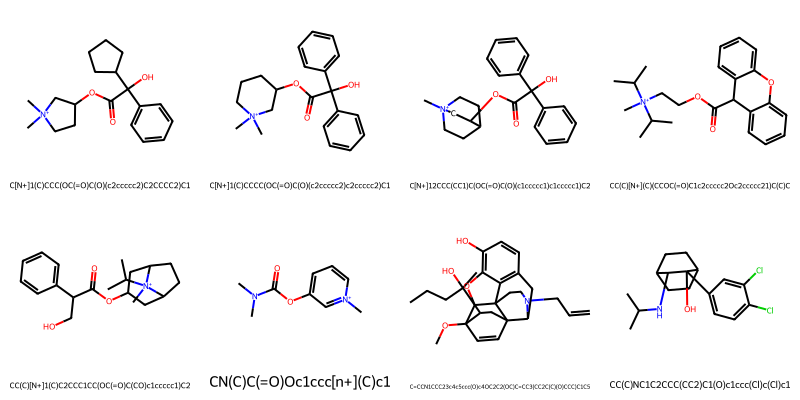

In [7]:
first_four_smiles = df['smiles'].head(8).tolist()
molecules = [Chem.MolFromSmiles(smile) for smile in first_four_smiles]
img = Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(200, 200), legends=first_four_smiles)
display(img)

In [8]:
df = canonicalize_smiles(df, smiles_col='smiles') 
test = canonicalize_smiles(test, smiles_col='smiles') 
duplicate_groups = df[df.duplicated(subset=['smiles'], keep=False)].groupby('smiles')
duplicate_groups = test[test.duplicated(subset=['smiles'], keep=False)].groupby('smiles')
df = df.drop_duplicates(subset='smiles', keep=False)
test = test.drop_duplicates(subset='smiles', keep=False)

### Feature generation for both df

In [9]:
feature_types = ['morgan', 'pubchem', 'rdkit2d', 'maccs', 'daylight', 'physchem']

df = add_molecular_features(df, smiles_col='smiles', feature_types=feature_types)
df = df.rename(columns={'SMILES': 'smiles'})

test = add_molecular_features(test, smiles_col='smiles', feature_types=feature_types)
test = test.rename(columns={'SMILES': 'smiles'})

In [10]:
if set(df.columns) == set(test.columns):
    print("Feature names in both DataFrames are identical.")
else:
    print("Feature names differ.")

    features_only_in_df = set(df.columns) - set(test.columns)
    features_only_in_test = set(test.columns) - set(df.columns)

    if features_only_in_df:
        print("Features only in df:", features_only_in_df)
    if features_only_in_test:
        print("Features only in test:", features_only_in_test)

Feature names in both DataFrames are identical.


### Random samplers to tackle class imbalance


In [11]:
X, y, smiles = prepare_data(df)
df_rus = under_sample(X, y, smiles)
df_ros = over_sample(X, y, smiles)

print("Original class distribution:")
print(df['BBB'].value_counts())
print("Random Under-Sampling class distribution:")
print(df_rus['BBB'].value_counts())
print("\nRandom Over-Sampling class distribution:")
print(df_ros['BBB'].value_counts())

Original class distribution:
1    1476
0     461
Name: BBB, dtype: int64
Random Under-Sampling class distribution:
0    461
1    461
Name: BBB, dtype: int64

Random Over-Sampling class distribution:
0    1476
1    1476
Name: BBB, dtype: int64


### t-SNE

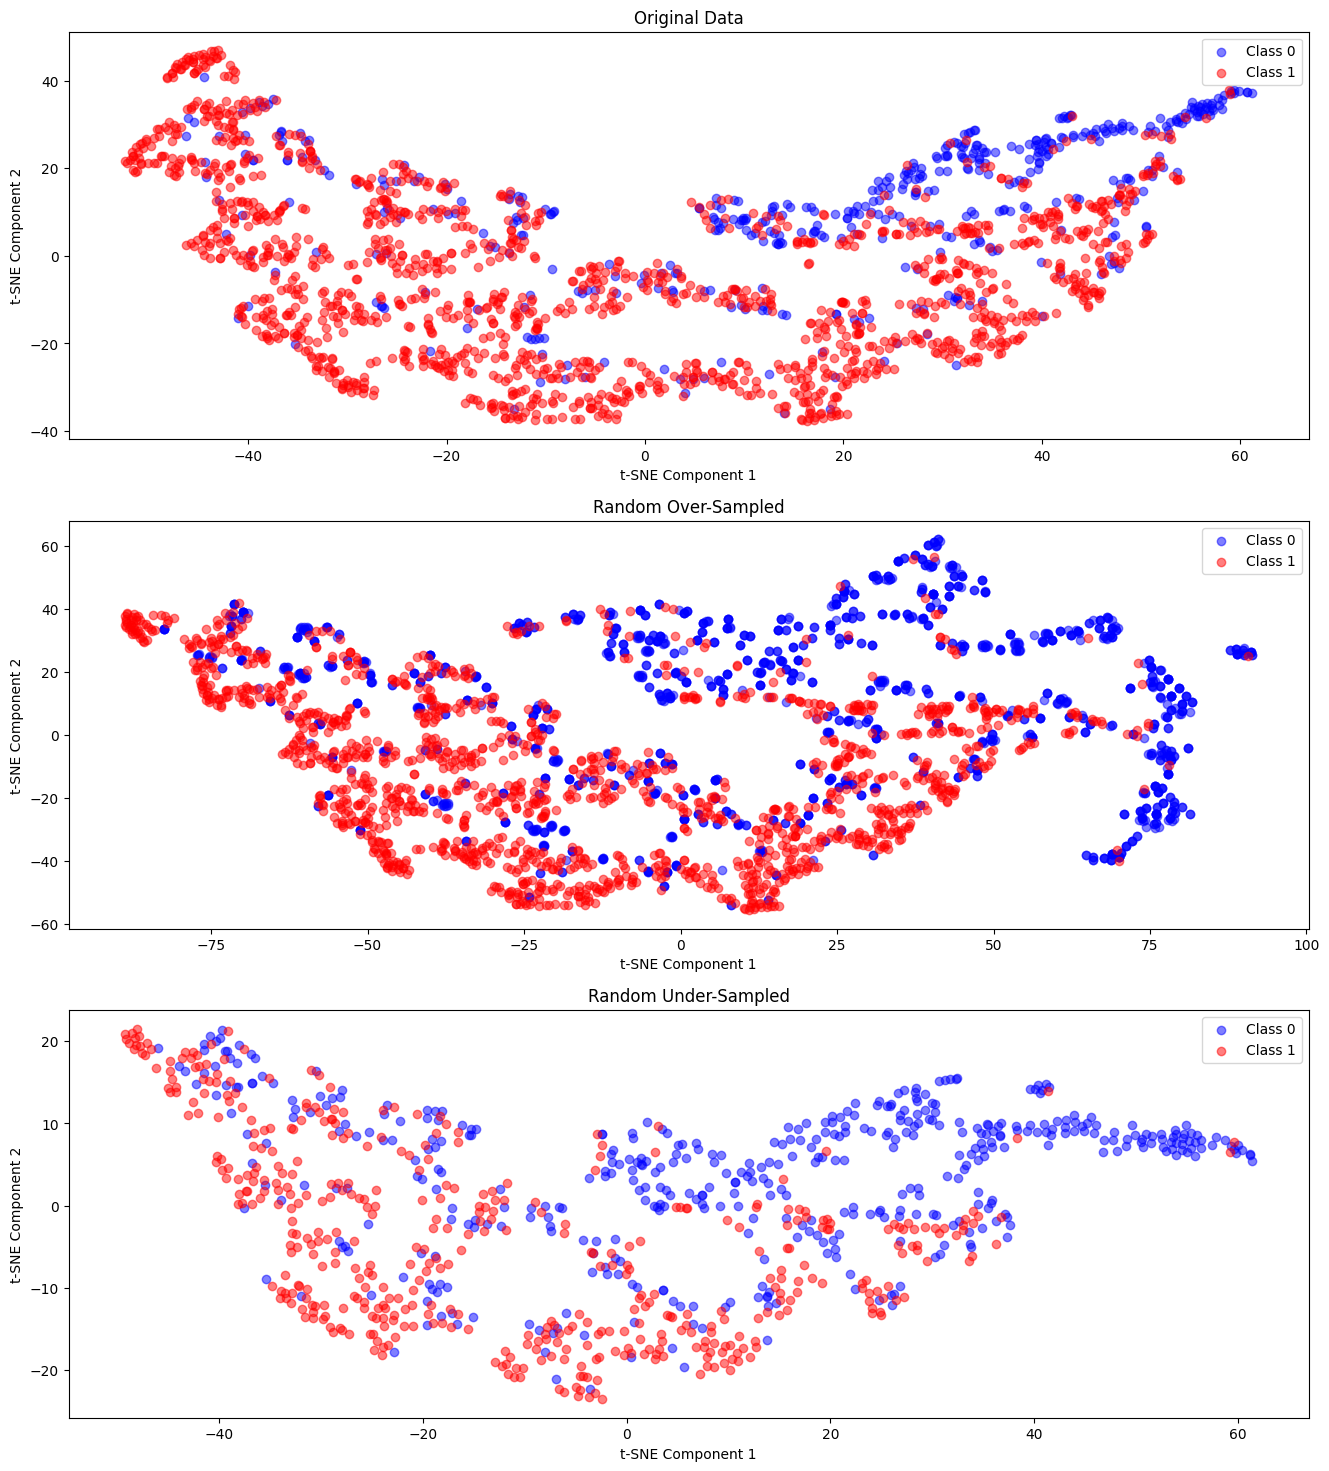

In [12]:
dfs = [df, df_ros, df_rus]
titles = ['Original Data', 'Random Over-Sampled', 'Random Under-Sampled']
plot_tsne(dfs, titles)

In [13]:
df_sel = df

### Baseline models

In [14]:
dfs = {
    'Imbalanced df': df,
    'Randomly undersampled df': df_rus,
    'Randomly oversampled df': df_ros
}

n_splits = 5  
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

trained_models = {}

for df_name, selected_df in dfs.items():
    feature_cols = selected_df.drop(['BBB', 'smiles'], axis=1).columns
    X = selected_df[feature_cols]
    y = selected_df['BBB']
    print(f"\nValidating models on {df_name}:")
    
    trained_models[df_name] = {}

    for name, model in models.items():
        fold_acc = [] 

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model_clone = clone(model)
            model_clone.fit(X_train, y_train)
            y_pred = model_clone.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            fold_acc.append(accuracy)

        avg_accuracy = sum(fold_acc) / len(fold_acc)
        print(f"  Model: {name}, Average Accuracy: {avg_accuracy:.4f}")
        
        trained_models[df_name][name] = model_clone


Validating models on Imbalanced df:
  Model: Logistic Regression, Average Accuracy: 0.9014
  Model: Decision Tree, Average Accuracy: 0.8508
  Model: Random Forest, Average Accuracy: 0.9112
  Model: Gradient Boosting, Average Accuracy: 0.8978
  Model: k-Nearest Neighbors, Average Accuracy: 0.8642
  Model: Naive Bayes, Average Accuracy: 0.7465

Validating models on Randomly undersampled df:
  Model: Logistic Regression, Average Accuracy: 0.8536
  Model: Decision Tree, Average Accuracy: 0.7929
  Model: Random Forest, Average Accuracy: 0.8721
  Model: Gradient Boosting, Average Accuracy: 0.8568
  Model: k-Nearest Neighbors, Average Accuracy: 0.7972
  Model: Naive Bayes, Average Accuracy: 0.7647

Validating models on Randomly oversampled df:
  Model: Logistic Regression, Average Accuracy: 0.9133
  Model: Decision Tree, Average Accuracy: 0.9319
  Model: Random Forest, Average Accuracy: 0.9695
  Model: Gradient Boosting, Average Accuracy: 0.9326
  Model: k-Nearest Neighbors, Average Accuracy

### Test trained models on exogenous dataset

In [15]:
features_ex = test.drop(columns=['BBB', 'smiles']).values
targets_ex = test['BBB'].values
smiles_ex = test['smiles'].values

valid_indices = validate_and_filter_smiles(smiles_ex)
valid_features_ex = features_ex[valid_indices]
valid_targets_ex = targets_ex[valid_indices]
valid_smiles_ex = smiles_ex[valid_indices]

test_dataset = dc.data.NumpyDataset(X=valid_features_ex, y=valid_targets_ex, ids=valid_smiles_ex)
sp(dc.splits.ScaffoldSplitter(), test_dataset)

def test_exogenous_models(trained_models, test_dataset, set_name="Test Set"):
    test_scores = {}
    for df_name, models_dict in trained_models.items():
        test_scores[df_name] = {}
        for model_name, model in models_dict.items():
            y_pred = model.predict(test_dataset.X)
            accuracy = dc.metrics.accuracy_score(test_dataset.y, y_pred)
            test_scores[df_name][model_name] = accuracy
    return test_scores

exogenous_test_scores = test_exogenous_models(trained_models, test_dataset)

def print_scores(scores, set_name):
    print(f"\n{set_name} Results:")
    for df_name, results in scores.items():
        print(f"\n  {df_name}:")
        for model_name, accuracy in results.items():
            print(f"    {model_name}: {accuracy:.4f}")

print_scores(exogenous_test_scores, "Exogenous Test Set")



Exogenous Test Set Results:

  Imbalanced df:
    Logistic Regression: 0.8686
    Decision Tree: 0.7314
    Random Forest: 0.8857
    Gradient Boosting: 0.8857
    k-Nearest Neighbors: 0.8362
    Naive Bayes: 0.6857

  Randomly undersampled df:
    Logistic Regression: 0.7962
    Decision Tree: 0.7676
    Random Forest: 0.8419
    Gradient Boosting: 0.8286
    k-Nearest Neighbors: 0.7390
    Naive Bayes: 0.6933

  Randomly oversampled df:
    Logistic Regression: 0.8400
    Decision Tree: 0.7981
    Random Forest: 0.8952
    Gradient Boosting: 0.8610
    k-Nearest Neighbors: 0.7600
    Naive Bayes: 0.7143


### AUC curve for baseline

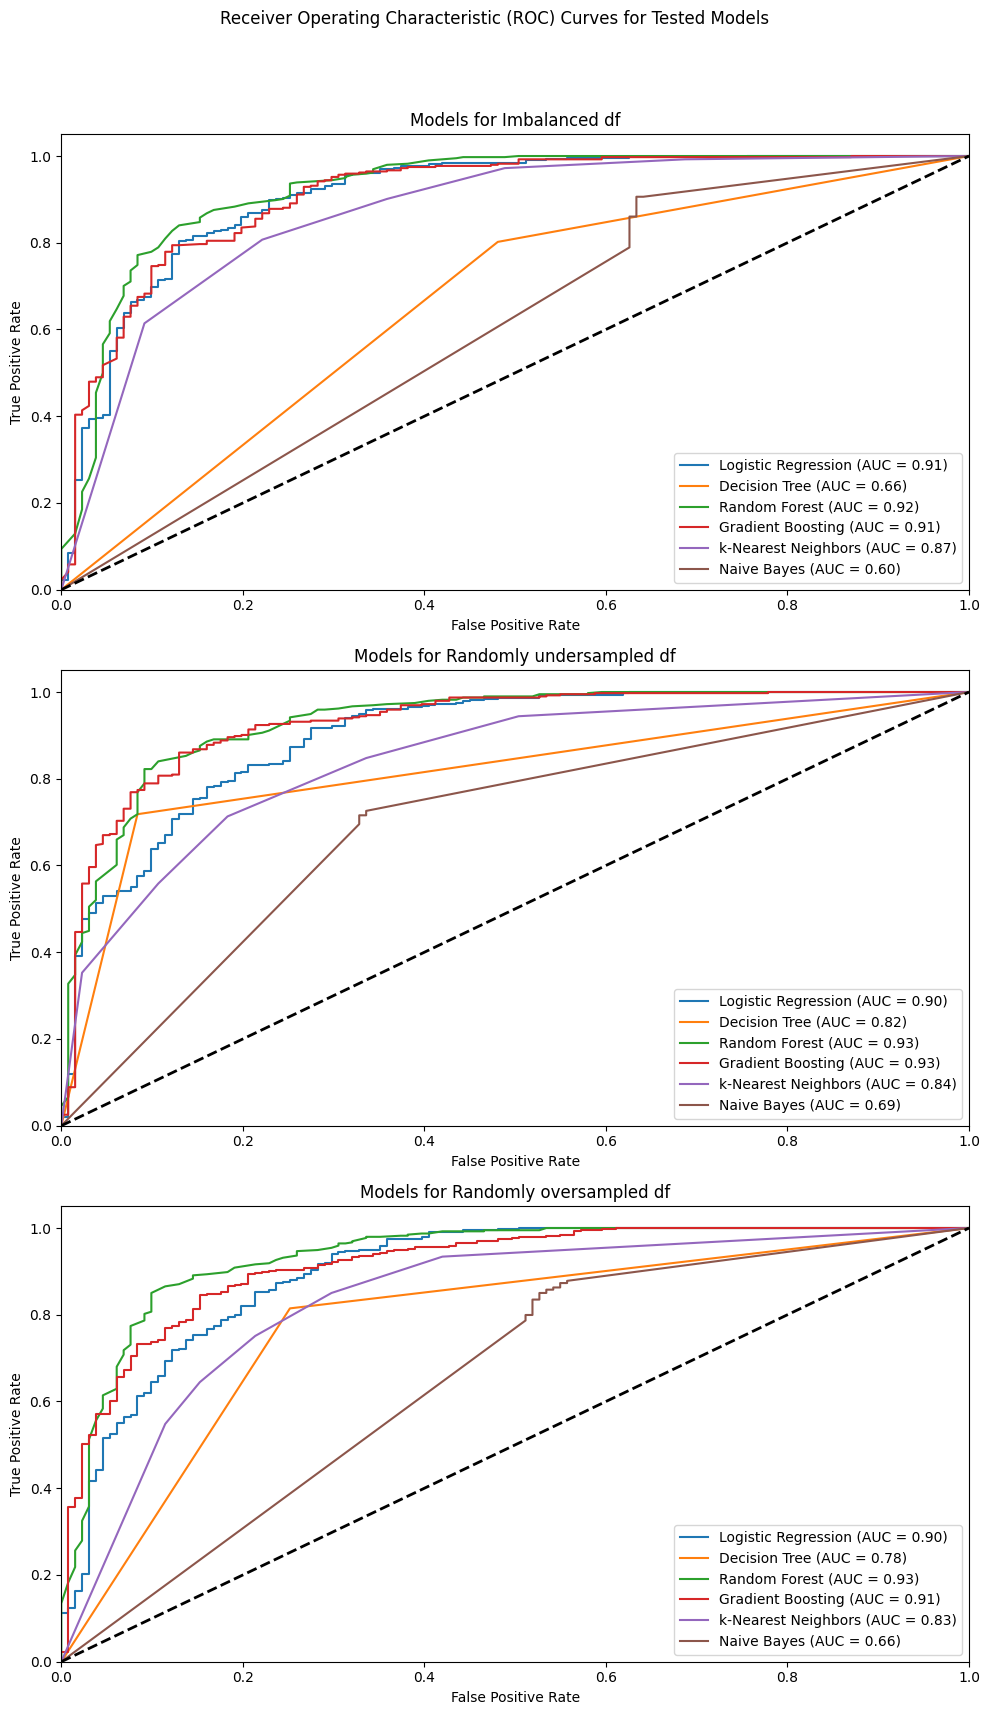

In [16]:
plot_roc_curves(trained_models, test_dataset)

### XAI and NN

In [18]:
#NN and XAI
X_drugs = df_ros['smiles'].tolist()
y = df_ros['BBB'].tolist()
drug_encoding = 'rdkit_2d_normalized'
train, val, test = utils.data_process(X_drug = X_drugs, y=y, drug_encoding=drug_encoding, split_method = "cold_split", frac=[0.7,0.1,0.2])

Drug Property Prediction Mode...
in total: 1937 drugs
encoding drug...
unique drugs: 1937
Done.


Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.67869. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.83659 , AUPRC: 0.90958 , F1: 0.82779
Training at Epoch 2 iteration 0 with loss 0.51228. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.85222 , AUPRC: 0.91408 , F1: 0.82779
Training at Epoch 3 iteration 0 with loss 0.54699. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.87168 , AUPRC: 0.92113 , F1: 0.90102
Training at Epoch 4 iteration 0 with loss 0.35688. Total time 0.0 hours
Validation at Epoch 4 , AUROC: 0.87501 , AUPRC: 0.91732 , F1: 0.92307
Training at Epoch 5 iteration 0 with loss 0.28799. Total time 0.00027 hours
Validation at Epoch 5 , AUROC: 0.87924 , AUPRC: 0.92056 , F1: 0.92465
Training at Epoch 6 iteration 0 with loss 0.40332. Total time 0.00027 hours
Validation at Epoch 6 , AUROC: 0.88346 , AUPRC: 0.92524 , F1: 0.92957
Training at Epoch 7 iteration 0 with loss 0.23823. Total time 0.00027 hour

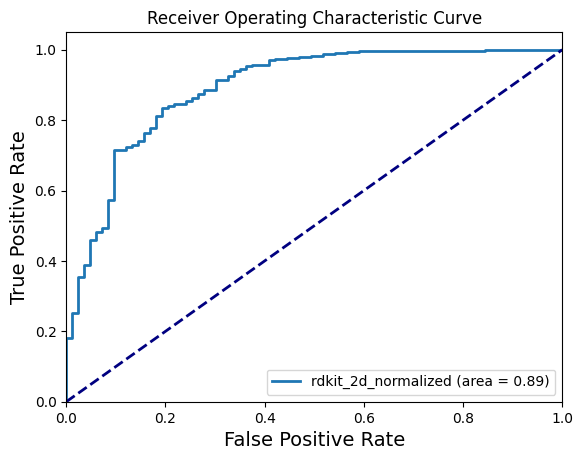

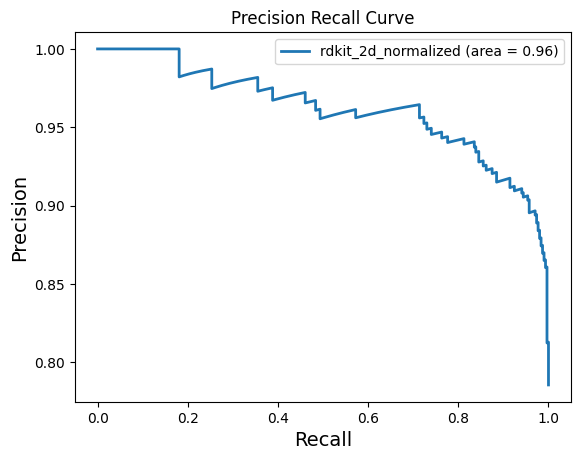

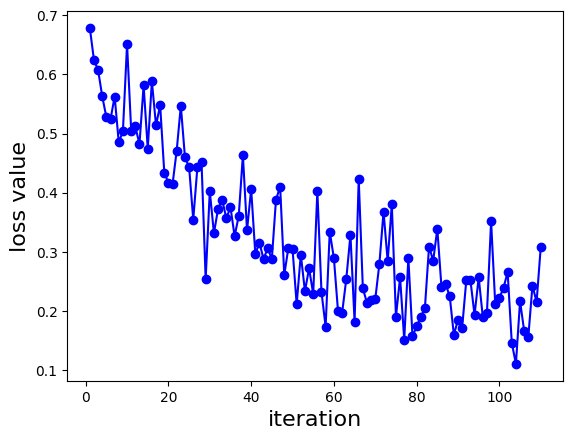

In [19]:
config = utils.generate_config(drug_encoding=drug_encoding,
mlp_hidden_dims_drug=[32, 8],
train_epoch=10,
LR=0.001,
batch_size=128)
model = CompoundPred.model_initialize(**config)
model.train(train, val, test)

In [20]:
def predictor(smiles):
    X_drug = [smiles]
    X_pred = utils.data_process(X_drug=X_drug, y=y, drug_encoding=drug_encoding,
                                split_method = 'no_split')
    y_pred = model.predict(X_pred)
    print('The precicted score is' + str(y_pred))
    answ = 1 if y_pred[0] > 0.5 else 0
    return answ

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.3318310081958771]


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:04<00:00, 792.03it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7250595688819885]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.8209095001220703]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9112046360969543]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.5276630520820618]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted

😀Calling your model function😀: 100%|██████████| 3000/3000 [00:20<00:00, 792.03it/s]

do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7073090076446533]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.8582198619842529]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.959740400314331]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.4018361568450928]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9622852206230164]
Drug Property Prediction Mode...
in total: 1 drugs
enco

😀Calling your model function😀:   0%|          | 0/2681 [00:00<?, ?it/s]            

do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9821223020553589]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9960452914237976]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.6515498161315918]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9000293016433716]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9348094463348389]
Drug Property Prediction Mode...
in total: 1 drugs
enc

🤘Done🤘: 100%|██████████| 2681.0/2681 [00:09<00:00, 295.19it/s]          


Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.22557473182678223]


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:04<00:00, 858.31it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.933841347694397]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.22557473182678223]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.6792691946029663]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.173129141330719]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted 

😀Calling your model function😀: 100%|██████████| 3000/3000 [00:21<00:00, 858.31it/s]

do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.980796217918396]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.4511213004589081]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9767144918441772]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9579777717590332]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.8340928554534912]
Drug Property Prediction Mode...
in total: 1 drugs
enco

😀Calling your model function😀:   0%|          | 0/2537 [00:00<?, ?it/s]            

do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9608314037322998]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9153322577476501]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.27054718136787415]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9751758575439453]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9792698621749878]
Drug Property Prediction Mode...
in total: 1 drugs
en

🤘Done🤘: 100%|██████████| 2537.0/2537 [00:07<00:00, 331.45it/s]          


Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9688596725463867]


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:00<00:00, 4935.53it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.960791289806366]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9787648916244507]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9566536545753479]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9687066078186035]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted 

🤘Done🤘: 100%|██████████| 358.0/358 [00:00<00:00, 2943.15it/s]                       

do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9557558298110962]


Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.3318310081958771]


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:04<00:00, 850.99it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.5906543731689453]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.2655017375946045]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9347321391105652]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.3318310081958771]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted

😀Calling your model function😀: 100%|██████████| 3000/3000 [00:16<00:00, 850.99it/s]

do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.29054713249206543]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9292737245559692]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.883530855178833]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7658014893531799]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7350649833679199]
Drug Property Prediction Mode...
in total: 1 drugs
enc

🔭Projecting...🔭:   0%|          | 0/2659 [00:00<?, ?it/s]                          

do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.12835226953029633]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9693323373794556]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9977542757987976]


🤘Done🤘: 100%|██████████| 2659.0/2659 [00:12<00:00, 220.65it/s]          


SMARTS annotations for MACCS descriptors were created using SMARTSviewer (smartsview.zbh.uni-hamburg.de, Copyright: ZBH, Center for Bioinformatics Hamburg) developed by K. Schomburg et. al. (J. Chem. Inf. Model. 2010, 50, 9, 1529–1535)
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.22557473182678223]


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:05<00:00, 662.96it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9705089926719666]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9638485312461853]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.8234454989433289]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.8696908354759216]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted

😀Calling your model function😀: 100%|██████████| 3000/3000 [00:18<00:00, 662.96it/s]

do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9658267498016357]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9487798810005188]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.6718538999557495]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9076783657073975]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.5631534457206726]
Drug Property Prediction Mode...
in total: 1 drugs
enc

🔭Projecting...🔭:  23%|██▎       | 582.5/2517 [00:00<00:00, 2915.81it/s]            

The precicted score is[0.9650722742080688]


🤘Done🤘: 100%|██████████| 2517.0/2517 [00:09<00:00, 267.82it/s]          


SMARTS annotations for MACCS descriptors were created using SMARTSviewer (smartsview.zbh.uni-hamburg.de, Copyright: ZBH, Center for Bioinformatics Hamburg) developed by K. Schomburg et. al. (J. Chem. Inf. Model. 2010, 50, 9, 1529–1535)
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9688596725463867]


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:00<00:00, 4313.70it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9496203660964966]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9787648916244507]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9566536545753479]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9691519141197205]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted

😀Calling your model function😀: 100%|██████████| 3000/3000 [00:12<00:00, 4313.70it/s]

do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9944826364517212]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7043769359588623]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.8280085921287537]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7851296067237854]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.8645673394203186]
Drug Property Prediction Mode...
in total: 1 drugs
enc

🥰Finishing up🥰: 100%|██████████| 349.0/349 [00:00<00:00, 6613.38it/s]               

do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9539379477500916]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.8959054946899414]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.9499175548553467]


🤘Done🤘: 100%|██████████| 349.0/349 [00:00<00:00, 2674.63it/s]        


SMARTS annotations for MACCS descriptors were created using SMARTSviewer (smartsview.zbh.uni-hamburg.de, Copyright: ZBH, Center for Bioinformatics Hamburg) developed by K. Schomburg et. al. (J. Chem. Inf. Model. 2010, 50, 9, 1529–1535)


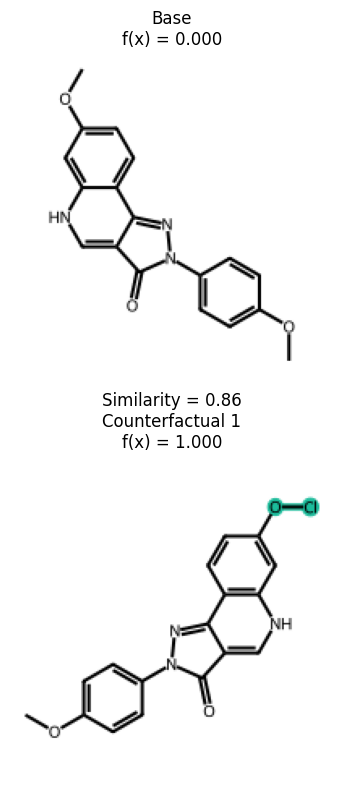

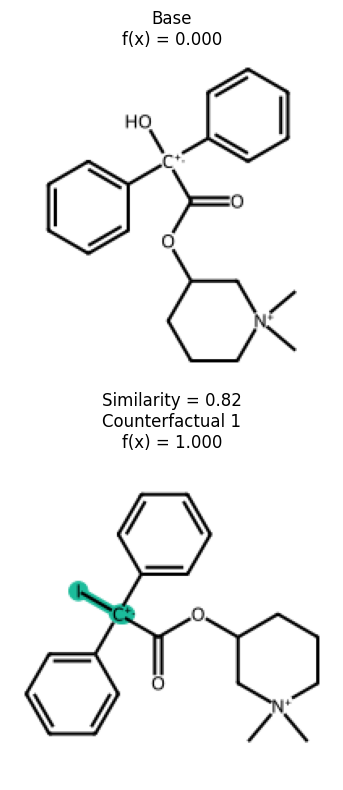

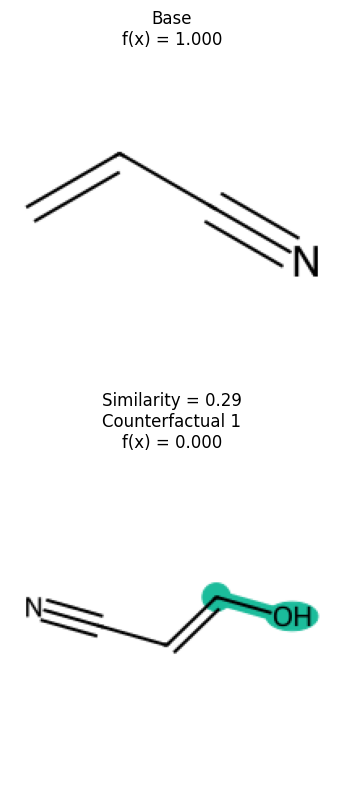

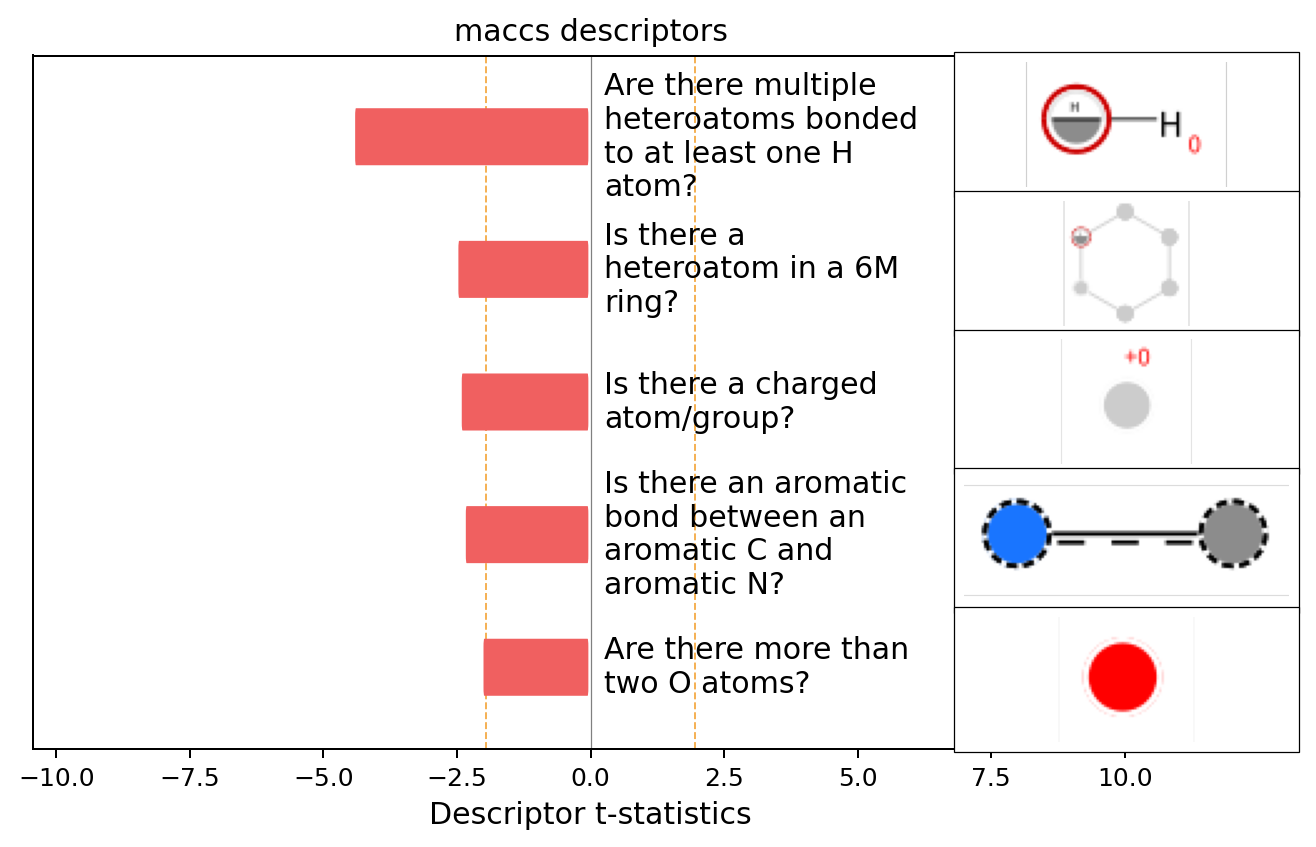

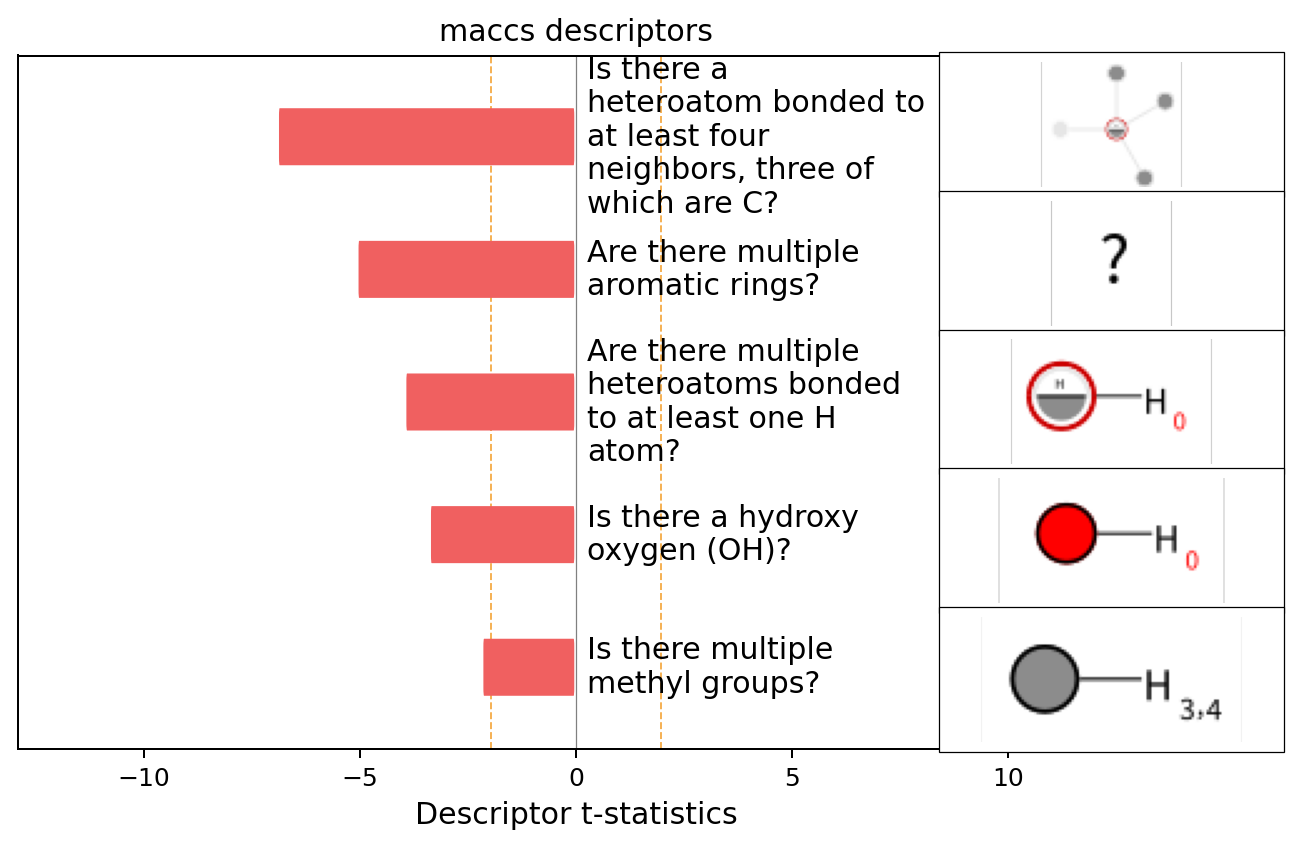

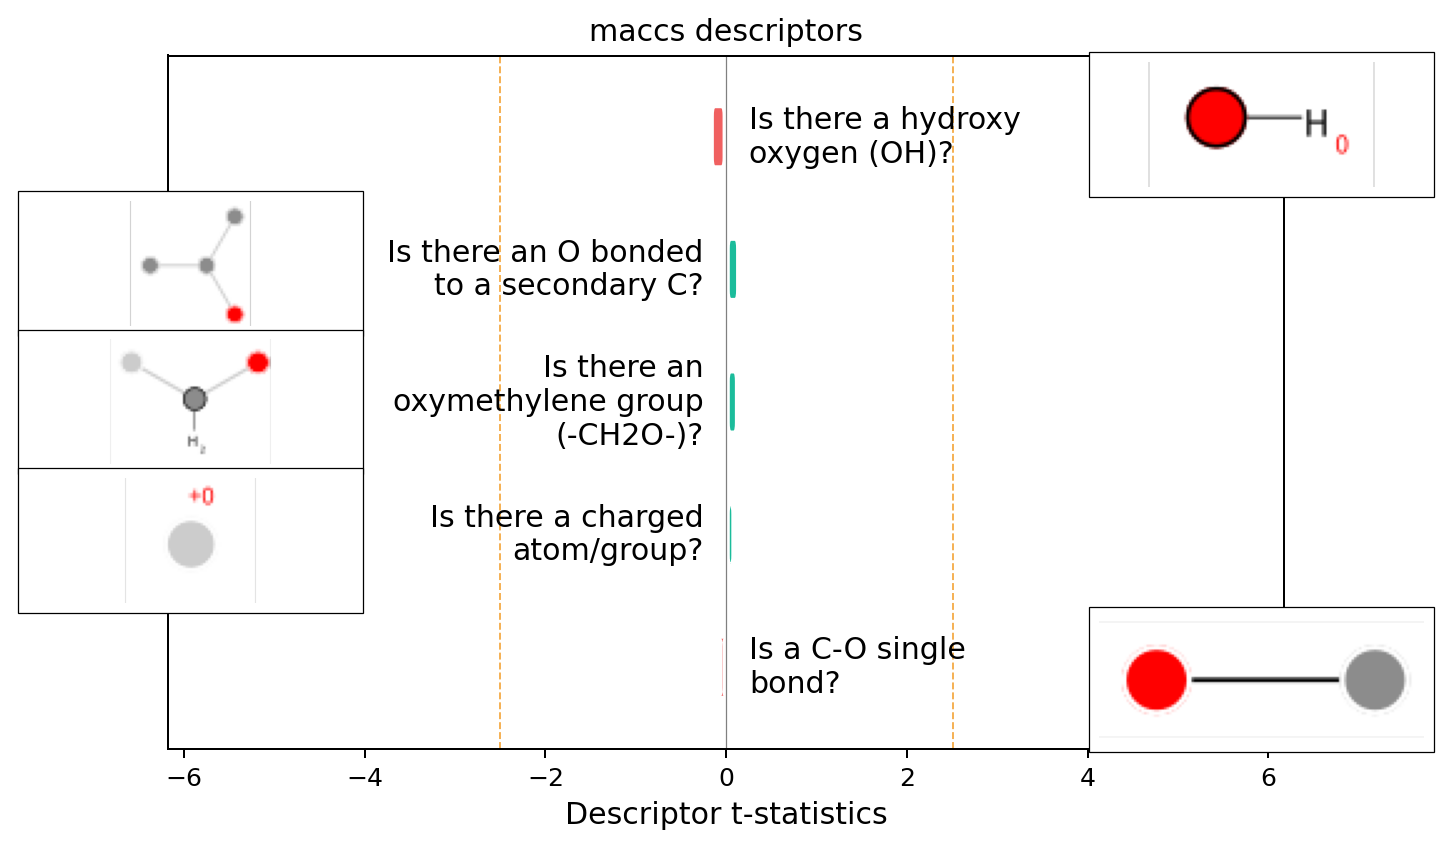

In [21]:
#available for user input!
smiles_list = [
    "[H]C([H])([H])Oc1ccc(-n2nc3c4ccc(OC([H])([H])[H])cc4[nH]cc-3c2=O)cc1",
    "C[N+]1(C)CCCC(OC(=O)[C+](O)(c2ccccc2)c2ccccc2)C1",
    "C=CC#N"
]

for smiles in smiles_list:
    space = exmol.sample_space(smiles, predictor, batched=False)
    cfs = exmol.cf_explain(space, 1)  
    exmol.plot_cf(cfs) 
    
for smiles in smiles_list:
    space = exmol.sample_space(smiles, predictor, batched=False)
    beta = exmol.lime_explain(space, return_beta=True)
    exmol.plot_descriptors(space)